1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method

Tick locating and formatting: [matplotlib.ticker — Matplotlib 3.5.0 documentation](https://matplotlib.org/stable/api/ticker_api.html)


Mean: 0.19993193743452356
Std: 0.9264335813664171


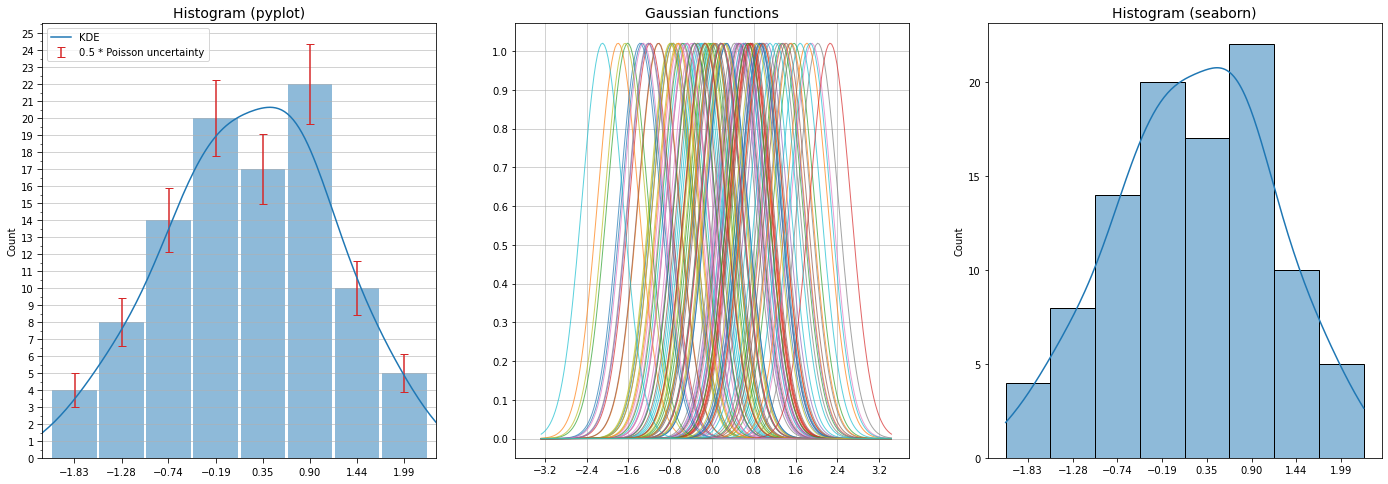

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.ticker import MultipleLocator, MaxNLocator, FixedLocator
from scipy.integrate import trapezoid
import math as m
import seaborn as sns

%matplotlib inline

N = 100
mu, sigma = 0, 1
x = sigma*np.random.randn(N)+mu

print('Mean:', x.mean())
print('Std:', x.std())

fig, (ax0, ax1, ax2) = plt.subplots(nrows = 1, ncols = 3, figsize=(24, 8))

n, bins, _ = ax0.hist(x, bins='auto', alpha=0.5, rwidth=0.95, color='C0')
# n, bins, _ = ax0.hist(x, bins=(np.linspace(x.min(), x.max(), int(m.sqrt(N)))), alpha=0.5, rwidth=0.95, color='C0')
bin_centers = 0.5*(bins[1:] + bins[:-1])

ax0.set_ylabel('Count')
ax0.grid(axis='y', alpha=0.7)
ax0.set_xlim(left = bins[0]-0.1, right=bins[-1]+0.1)

ax0.yaxis.set_major_locator(MultipleLocator(1))
ax0.yaxis.set_minor_locator(MultipleLocator(0.5))
ax0.xaxis.set_major_locator(FixedLocator(np.around(bin_centers, 2)))
ax0.tick_params(which='major', length=5)

ax0.errorbar(bin_centers, n, yerr=np.sqrt(n)/2, ls='none', label='0.5 * Poisson uncertainty', ecolor='C3', capsize=4, lolims=0)
# for a better aesthetic, I prefer to set the errorbar size to sqrt(n)/2 instead of sqrt(n)

# --------------------------------------------------------------------------------------------------

xstd = 1.06 * x.std() * x.size**(-1/5.)
xplot = np.linspace(-3*xstd+min(x), 3*xstd+max(x), 200)

gauss_funcs = np.array(norm.pdf(xplot, loc=x[0], scale=xstd))  # loc is the mean, scale the standard deviation 
for mean in x[1:]:
    gauss_funcs = np.vstack((gauss_funcs, norm.pdf(xplot, loc=mean, scale=xstd)))

ax1.plot(xplot, gauss_funcs.T, lw=1, alpha=0.7);
ax1.grid(alpha=0.7)
ax1.set_title('Gaussian functions', fontsize=14)
ax1.yaxis.set_major_locator(MultipleLocator(0.1))
ax1.xaxis.set_major_locator(MaxNLocator(symmetric=True))

gauss_sum = np.sum(gauss_funcs, axis=0)
hist_int = np.sum([(bins[i+1]-bins[i])*n[i] for i in range(len(n))])
gauss_norm = gauss_sum*hist_int/trapezoid(gauss_sum, xplot)

ax0.plot(xplot, gauss_norm, lw=1.5, color='C0', label='KDE')
ax0.set_title('Histogram (pyplot)', fontsize=14)
ax0.legend(loc='best');


# --------------------------------------------------------------------------------------------------
# SEABORN
ax2 = sns.histplot(x, kde=True)
ax2.set_title('Histogram (seaborn)', fontsize=14);
ax2.xaxis.set_major_locator(FixedLocator(np.around(bin_centers, 2)))


2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

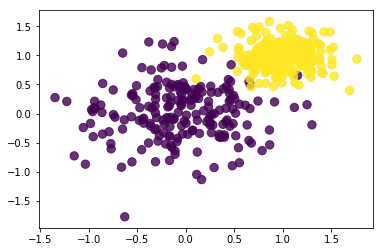

In [2]:
# ! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

,x,y,category
0,1.332731,-0.453519,1
1,0.033090,0.579167,1
2,1.181838,0.262517,1
3,0.169386,-0.975437,1
4,1.059425,0.427449,1
...,...,...,...
795,5.906605,7.267362,2
796,4.903966,5.458990,2
797,5.505973,4.343282,2
798,2.992893,3.688537,2


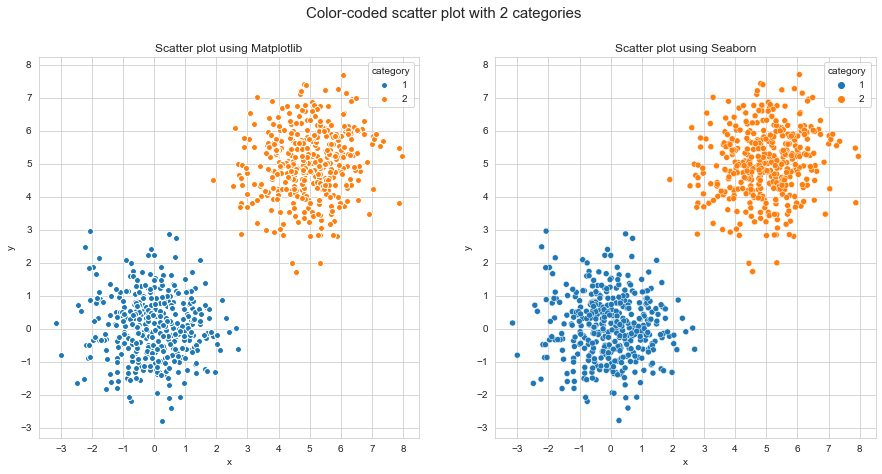

In [3]:
from IPython.display import display
from matplotlib.ticker import MultipleLocator
import seaborn as sns
sns.set_style('whitegrid')

def create_dataset(N_cat, N_points, means, stds):
    import pandas as pd
    import numpy as np
    
    data = []
    categories = []
    
    for n in range(N_cat):
        mean = means[n]
        cov = stds[n]
        
        data.append(np.random.multivariate_normal(mean, cov, N_points))
        categories += [str(n+1)]*N_points
        
    data = np.array(data).reshape(-1, 2)
    
    return pd.DataFrame({'x': data[:, 0], 'y': data[:, 1], 'category': categories})
    
data1 = create_dataset(2, 400, [[0, 0], [5, 5]], [[[1, 0], [0, 1]], [[1, 0], [0, 1]]])
display(data1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
fig.suptitle('Color-coded scatter plot with 2 categories', fontsize=15)

ax1.scatter(x=data1['x'][data1['category']=='1'], y=data1['y'][data1['category']=='1'], marker='o', c='C0', edgecolors='w', label='1')
ax1.scatter(x=data1['x'][data1['category']=='2'], y=data1['y'][data1['category']=='2'], marker='o', c='C1', edgecolors='w', label='2')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.yaxis.set_major_locator(MultipleLocator(1))
ax1.set_title('Scatter plot using Matplotlib')
ax1.legend(title='category')

# USING SEABORN
sns.scatterplot(x = 'x', y = 'y', data=data1, hue='category', ax=ax2)
ax2.xaxis.set_major_locator(MultipleLocator(1))
ax2.yaxis.set_major_locator(MultipleLocator(1))
ax2.set_title('Scatter plot using Seaborn');    
    
    

C:\Users\Nicola\AppData\Local\Temp/ipykernel_24788/2972122588.py:17: RuntimeWarning: covariance is not positive-semidefinite.
  data.append(np.random.multivariate_normal(mean, cov, N_points))


,x,y,category
0,-2.190894,-2.102629,1
1,-2.667593,-3.090527,1
2,-3.896416,-4.652825,1
3,-3.703492,-4.142393,1
4,-2.660062,-1.571400,1
...,...,...,...
1195,1.788120,1.397715,4
1196,3.027496,5.178329,4
1197,3.757938,1.272152,4
1198,2.940958,2.940849,4


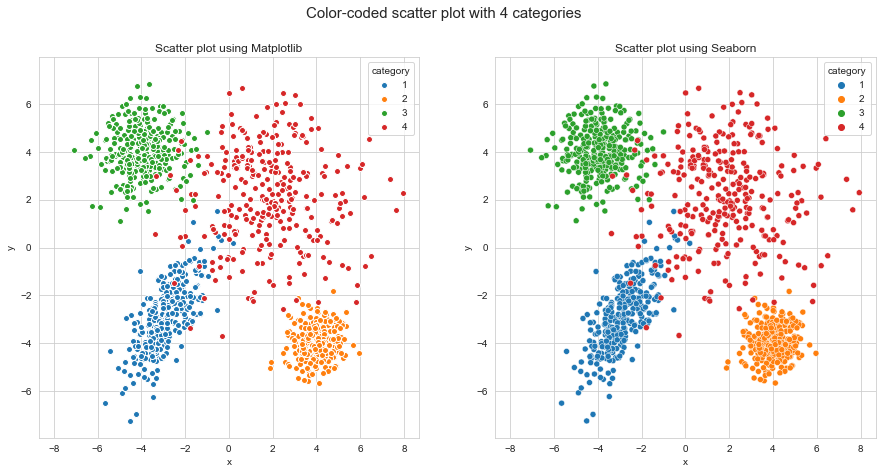

In [4]:
from matplotlib.ticker import MaxNLocator

data2 = create_dataset(4, 300, [[-3, -3], [4, -4], [-4, 4], [2, 2]], [[[1, 2], [1, 1]], [[0.4, 0], [0, 0.4]], [[1, 0], [0, 1]], [[4, 0], [0, 4]]])
display(data2)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
fig.suptitle('Color-coded scatter plot with 4 categories', fontsize=15)

ax1.scatter(x=data2['x'][data2['category']=='1'], y=data2['y'][data2['category']=='1'], marker='o', c='C0', edgecolors='w', label='1')
ax1.scatter(x=data2['x'][data2['category']=='2'], y=data2['y'][data2['category']=='2'], marker='o', c='C1', edgecolors='w', label='2')
ax1.scatter(x=data2['x'][data2['category']=='3'], y=data2['y'][data2['category']=='3'], marker='o', c='C2', edgecolors='w', label='3')
ax1.scatter(x=data2['x'][data2['category']=='4'], y=data2['y'][data2['category']=='4'], marker='o', c='C3', edgecolors='w', label='4')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.xaxis.set_major_locator(MaxNLocator(symmetric=True))
ax1.yaxis.set_major_locator(MaxNLocator(symmetric=True))
ax1.set_title('Scatter plot using Matplotlib')
ax1.legend(title='category')

# USING SEABORN
sns.scatterplot(x = 'x', y = 'y', data=data2, hue='category', ax=ax2)
ax2.xaxis.set_major_locator(MaxNLocator(symmetric=True))
ax2.yaxis.set_major_locator(MaxNLocator(symmetric=True))
ax2.set_title('Scatter plot using Seaborn');   

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy -O ~/data/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor (pickling is a way to convert a python object (list, dict, etc.) into a character stream).
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot


,residuals,distances
0,1.10,16.0
1,-1.95,6.3
2,-7.20,3.4


Starting shape: (11131, 2)
Shape after cleaning: (10489, 2)

Regression line: y = 0.58x + 10.03

Minimum distance: 0.0 
Maximum distance: 24.899999999999977


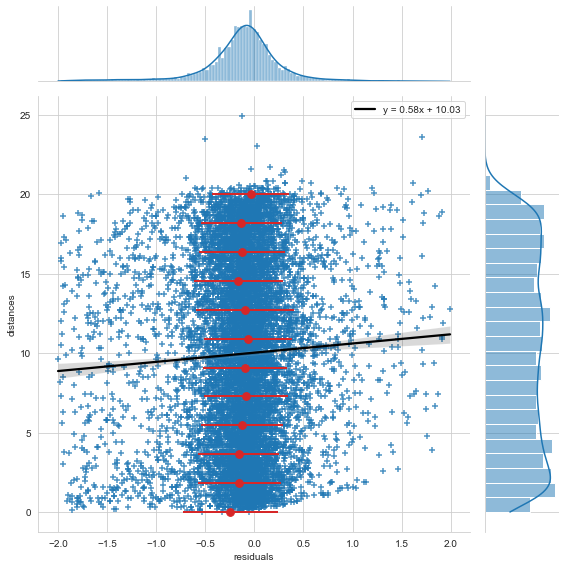

In [5]:
import pandas as pd
from scipy.stats import linregress

filename = '/Users/Nicola/data/residuals_261.npy'
dataframe = pd.DataFrame(np.load(filename, allow_pickle=True).item())
display(dataframe.head(3))
print('Starting shape:', dataframe.shape)

dataframe = dataframe[abs(dataframe['residuals'])<2]
print('Shape after cleaning:', dataframe.shape)

lin_reg = linregress(dataframe)
line_label = 'y = '+str(round(lin_reg.slope, 2))+'x + '+str(round(lin_reg.intercept, 2))
print('\nRegression line:', line_label)

g = sns.jointplot(data=dataframe, x='residuals', y='distances', kind='reg', color='C0', height=8, marker='+',
                  joint_kws={'line_kws':{'color':'black', 'label':line_label}, 'scatter_kws':{'alpha': 0.8}})

# xplot = np.linspace(dataframe.residuals.min(), dataframe.residuals.max(), 100)
# g.ax_joint.plot(xplot, lin_reg.intercept + xplot*lin_reg.slope, color='C6') # same result as jointplot

print('\nMinimum distance:', dataframe['distances'].min(), '\nMaximum distance:', dataframe['distances'].max())
x = np.linspace(0, 20, 12)
bins_size = x[1]-x[0]
bins = np.append(x-0.5*bins_size, x[-1]+0.5*bins_size)

y = [dataframe['residuals'][dataframe['distances'].between(bins[i], bins[i+1])].mean() for i in range(len(bins)-1)]
erry = [dataframe['residuals'][dataframe['distances'].between(bins[i], bins[i+1])].std() for i in range(len(bins)-1)]

g.ax_joint.scatter(y, x, color='C3', s=60)
g.ax_joint.errorbar(y, x, xerr=erry, ecolor='C3', ls='none', lw=2)
g.ax_joint.legend();
